In [2]:
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
# デバイスの設定
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'using {device} device')

using mps device


In [13]:
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=not os.path.exists('data/FashionMNIST/raw/train-images-idx3-ubyte.gz'),
    transform=transforms.ToTensor())

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=not os.path.exists('data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz'),
    transform=transforms.ToTensor())

train_data_loader = DataLoader(training_data, batch_size=64)
test_data_loader = DataLoader(test_data, batch_size=64)

In [14]:
class Cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

In [15]:
# https://pystyle.info/pytorch-cnn-based-classification-model-with-fashion-mnist/
def train_through_an_epoch(model, device, data_loader, optim):
    model.train()

    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        # データ及びラベルを計算を実行するデバイスに転送する。
        data, target = data.to(device), target.to(device)

        # 順伝搬を行う。
        output = model(data)

        # 損失関数の値を計算する。
        loss = nll_loss(output, target)
        total_loss += float(loss)

        # 逆伝搬を行う。
        # zero_gradをすることで勾配を初期化
        # これをやらないと前回の勾配に累積する形となる
        # 今回はbatch毎に勾配を求めて更新するため，やる
        optim.zero_grad()
        loss.backward()

        # パラメータを更新する。
        optim.step()

        # 確率の最も高いクラスを予測ラベルとする。
        pred_target = output.argmax(dim=1)

        # 正答数を計算する。
        total_correct += int((pred_target == target).sum())

    # 損失関数の値の平均及び精度を計算する。
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = total_correct / len(data_loader.dataset)

    return avg_loss, accuracy

In [16]:
def test_through_an_epoch(model, device, data_loader):
    """
    テストデータに対する損失の平均及び精度を計算する。
        :param model: モデル
        :param device: デバイス
        :param data_loader: Data Loader
    """
    # モデルをテストモードに設定する。
    model.eval()

    with torch.no_grad():
        total_loss = 0
        total_correct = 0
        for data, target in data_loader:
            # データ及びラベルを計算を実行するデバイスに転送する。
            data, target = data.to(device), target.to(device)

            # 順伝搬する。
            output = model(data)

            # 損失を計算する。
            loss = nll_loss(output, target)
            total_loss += float(loss)

            # 確率の最も高いクラスを予測ラベルとする。
            pred_target = output.argmax(dim=1)

            # 正答数を計算する。
            total_correct += int((pred_target == target).sum())

    # 損失の平均及び精度を計算する。
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = total_correct / len(data_loader.dataset)

    return avg_loss, accuracy

In [19]:
from collections import defaultdict

n_epochs = 50

nll_loss = nn.NLLLoss()
model = Cnn().to(device)
optim = torch.optim.Adam(model.parameters())

history = defaultdict(list)
for epoch in range(n_epochs):
    # 1エポック分、学習する。
    train_loss, train_accuracy = train_through_an_epoch(model, device, train_data_loader, optim)
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)

    # 評価する。
    test_loss, test_accuracy = test_through_an_epoch(model, device, test_data_loader)
    history["test_loss"].append(test_loss)
    history["test_accuracy"].append(test_accuracy)

    print(
        f"epoch {epoch + 1} "
        f"[train] loss: {train_loss:.6f}, accuracy: {train_accuracy:.0%} "
        f"[test] loss: {test_loss:.6f}, accuracy: {test_accuracy:.0%}"
    )

epoch 1 [train] loss: 0.009039, accuracy: 79% [test] loss: 0.006003, accuracy: 87%
epoch 2 [train] loss: 0.006215, accuracy: 86% [test] loss: 0.005058, accuracy: 88%
epoch 3 [train] loss: 0.005475, accuracy: 87% [test] loss: 0.004629, accuracy: 89%
epoch 4 [train] loss: 0.005006, accuracy: 88% [test] loss: 0.004415, accuracy: 90%
epoch 5 [train] loss: 0.004727, accuracy: 89% [test] loss: 0.004185, accuracy: 90%
epoch 6 [train] loss: 0.004486, accuracy: 89% [test] loss: 0.004142, accuracy: 91%
epoch 7 [train] loss: 0.004292, accuracy: 90% [test] loss: 0.004087, accuracy: 90%
epoch 8 [train] loss: 0.004104, accuracy: 90% [test] loss: 0.003705, accuracy: 91%
epoch 9 [train] loss: 0.004056, accuracy: 90% [test] loss: 0.003786, accuracy: 91%
epoch 10 [train] loss: 0.003861, accuracy: 91% [test] loss: 0.003576, accuracy: 92%
epoch 11 [train] loss: 0.003795, accuracy: 91% [test] loss: 0.003615, accuracy: 92%
epoch 12 [train] loss: 0.003668, accuracy: 91% [test] loss: 0.003584, accuracy: 92%
e

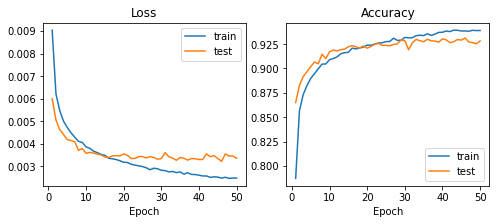

In [21]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, n_epochs + 1)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 3))

# 損失の推移
ax1.set_title("Loss")
ax1.plot(epochs, history["train_loss"], label="train")
ax1.plot(epochs, history["test_loss"], label="test")
ax1.set_xlabel("Epoch")
ax1.legend()

# 精度の推移
ax2.set_title("Accuracy")
ax2.plot(epochs, history["train_accuracy"], label="train")
ax2.plot(epochs, history["test_accuracy"], label="test")
ax2.set_xlabel("Epoch")
ax2.legend()

plt.show()